## Introduction

"Persuasion for Good: Towards a Personalized Persuasive Dialogue System for Social Good" is  paper that discusses the intricacies of constructing dialogue system with the intent of persuading others, however, also takes a stand on the ethical implications on such a device. To put it simply there is no one-size-fits-all in regard to persuasion, as every persuader is different and every persuadee is different, a dynamic system requires a dynamic solution. Subsequently it leads to the goal of personalized persuasion, to produce desired result by making appropriate changes to the persuasive strategies used, in other words, devise a system that can make the information personally relevant and appealing. As the paper puts it, there are two main concerns, first how personal background information affects persuasion outcomes, and secondly, which strategies are the most effective when considering different backgrounds and personalities.

This leads directly to this investigation, I hope to begin answering the question posed by the second concern: 

### What strategies are most effective when taking into accound background info?

The dataset the investigation will use is comprised of 108 successful dialogues (i.e. resulted in a donation of any amount) and 108 unsuccessful dialogues (i.e. resulted in no actual donation).

First, the data will be loaded from 3 different origin files into Pandas dataframes, and then be concatenated together depending on their final purpose.
Secondly, an n-gram distribution will be performed on the dataset in the form of unigram, bigram, and trigram.
Finally the data will be visualized and the top 5 strategies form each dataset is printed along with its distribution in it's respective corpora.

What this data will visualize is the deviation of each n-gram in the corpora from even usage at 50%. It should be said the larger the deviation the more useful the particular n-gram is in determining unique features that increase or decrease the chance of success. The choice for performing an n-gram analysis is derived from the variation in dialogues, or simply how one changes the way they talk to compensate for differences within the receiving end. Furthermore, when adding the layer of personal background information, it will allow for a more specific analysis for which strategies or sequence of strategies is most useful in a given situation, thus providing a basic solution to the question posed.


In [2]:
# Importing Libraries for Loading Data 
import pandas as pd
import random
import nltk
from nltk.collocations import * 
import matplotlib.pyplot as plt
from persuasion import * # Import for Custom Modules

## Loading Data w/o Persuadee Background

In [3]:

''' Initializing Data Frame '''

# Initializing ID and Persuasion Strategy data
# from 'xlsx' file in the form of Pandas Dataframe

ps_df = pd.read_excel(r'dialog.xlsx')
ps_df = ps_df[ps_df.B4 != 1]
ps_df = ps_df.reset_index()
ps_df.drop(['Unnamed: 0', 'index', 'B4', 'Turn',
            'Unit', 'ee_label_1', 'ee_label_2',
            'er_label_2', 'neg', 'neu', 'pos'],
           inplace=True, axis=1)

# Initializing ID and Donation Amount data
# from 'xlsx' file in the form of a Pandas Dataframe

da_df = pd.read_excel(r'info.xlsx')
da_df = da_df.sort_values('B2')
da_df = da_df[da_df.B4 != 1]
da_df = da_df.reset_index()
da_df.drop(['index', 'B3', 'B4', 'B5', 'B7'],
           inplace=True, axis=1)


## Loading Data w/ Persuadee Background

In [4]:

profile_df = pd.read_csv(r'full_info.csv')
profile_df = profile_df.sort_values('B2')
profile_df = profile_df[profile_df.B4 != 0]
profile_df = profile_df.reset_index()
profile_df.drop([ 'index', 'B3', 'B4', 'B6', 'B7'],
           inplace=True, axis=1)

## Processing Data w/o Persuadee Background

In [5]:

''' Creating list of dictionaries of Dialogue IDs and Persuasive Strategies '''

# declaring Variables
id_list = []
s_list = []
data_dict = {}
id_and_ps = []

# iterating through rows of data frame
for pos, row in enumerate(ps_df.itertuples()):

    # new ID check
    if row[1] not in id_list:
        id_list.append(row[1])  # add new id to list
        current = id_list[-1]  # current is top of the stack

        if len(id_list) == 1:
            previous = current  # if there is only 1 id then the current is the previous
        else:
            previous = id_list[-2]  # ID under current in stack

        if previous != current:

            s_list.append('<eos>')
            # swapping memory spots for s_list
            s = s_list
            s_list = []

            # appending this iteration to temporary dictionary
            data_dict['Dialogue ID'] = previous
            data_dict['Strategies'] = s

            # swapping memory spots for data_dict
            i = data_dict
            data_dict = {}

            # appending to the id_and_ps list
            id_and_ps.append(i)

    # strategy list add
    if current == row[1]:
        if not s_list:
            s_list.append('<sos>')
        s_list.append(row[2])

    # if it is the end
    if pos == (len(ps_df)-1):

        s_list.append('<eos>')
        # swapping memory spots for s_list
        s = s_list
        s_list = []

        # appending this iteration to temporary dictionary
        data_dict['Dialogue ID'] = current
        data_dict['Strategies'] = s

        # swapping memory spots for data_dict
        i = data_dict
        data_dict = {}

        # appending to the id_and_ps list
        id_and_ps.append(i)


In [6]:


# ID and the Big-Five traits
id_and_profile = [{'Dialogue ID': row[1], 'Extrovert': row[2], 'Agreeable': row[3], 
                    'Conscientious': row[4], 'Neurotic': row[5], 'Open': row[6]} 
                    for row in profile_df.itertuples() if row[1] in id_list] 

In [7]:


# ID and persuasion strategies
id_and_ps = sorted(id_and_ps, key=lambda x: x['Dialogue ID']) 

# ID and donation
id_and_donation = [{'Dialogue ID': row[1], 'Donation': row[2]}
                   for row in da_df.itertuples()]

data = [Merge(id_and_ps[pos], id_and_donation[pos])
        for pos, i in enumerate(id_and_ps)]

data_pos = []
data_neg = []

for d in data:
    if d['Donation'] > 0:
        data_pos.append(d)
    else:
        data_neg.append(d)

pos_df = pd.DataFrame(data_pos[:len(data_pos)])
neg_df = pd.DataFrame(data_neg[:len(data_pos)])


In [8]:
# converting dataframes into corpora for NLTK manipulation

pos_corpus = [row[2] for row in pos_df.itertuples()]
neg_corpus = [row[2] for row in neg_df.itertuples()]

corpora = [pos_corpus, neg_corpus]

In [9]:
data2 = [Merge(Merge(id_and_ps[pos], id_and_donation[pos]), 
        id_and_profile[pos]) for pos, i in enumerate(id_and_ps)]

In [10]:
# creating data frame based on length of n-gram

unigram_df = n_gram_freq_df(corpora, n=1)
bigram_df = n_gram_freq_df(corpora, n=2)
trigram_df = n_gram_freq_df(corpora, n=3)

## Statistical Analysis of data w/o Persuadee Background

<AxesSubplot:>

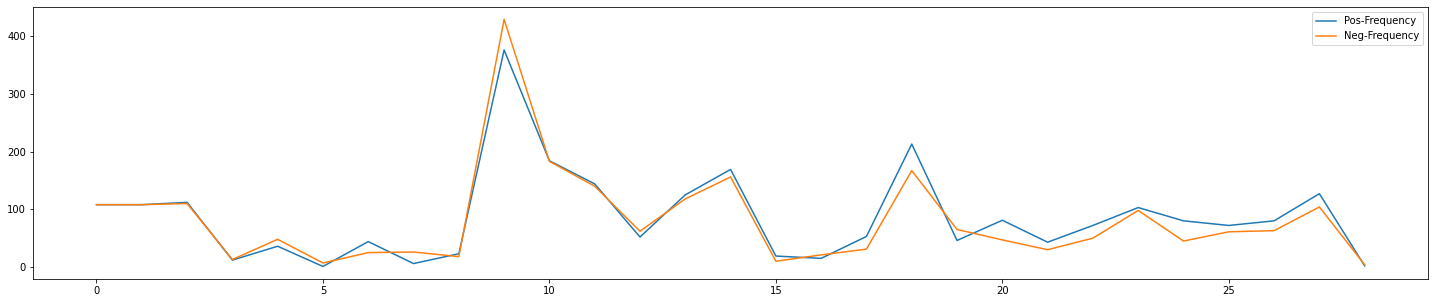

In [11]:
unigram_df.plot(figsize=(25,5))


## Analysis of the Unigram Distribution:

With the intention of isloating what makes a successful persuasive dialogue one must take into account the prescence of strategies used. 
After separating Successful dialogues and unsuccessful ones, one can compare the distriution of strategies across both.
Visualized in the graph by both successful and unsuccesful counts, there doesnt seem to be a noticeable differences between strategies with the distribution being nearly even for both datasets.

The most used strategies

* credibility-appeal
* other
* donation-information
* emotion-appeal
* logical-appeal


My interpretation of this pattern is that when the subjects from the "Persuasion for Good" experiment were tasked with being a persuader they had a predetermined idea of what would work, causing a lot of overlap between different persuader dialogues in terms of structure. 
Even after taking into consideration potential overlapping unigrams, the percentage of use per strategy remains close to 50%, meaning the strategies are distributed nearly even between successful and unseccessful dialogues.

In [12]:

export_top_5(unigram_df, True) # Top 5 Unigrams given overlap


N-Gram Number: 1   
Top Successful N-Gram: credibility-appeal                                   Percentage of use: 46.70807453416149%  
Top Unsuccessful N-Gram: credibility-appeal                                 Percentage of use: 53.29192546583851%

N-Gram Number: 2   
Top Successful N-Gram: other                                                Percentage of use: 56.05263157894736%  
Top Unsuccessful N-Gram: donation-information                               Percentage of use: 49.863760217983646%

N-Gram Number: 3   
Top Successful N-Gram: donation-information                                 Percentage of use: 50.13623978201635%  
Top Unsuccessful N-Gram: other                                              Percentage of use: 43.94736842105263%

N-Gram Number: 4   
Top Successful N-Gram: logical-appeal                                       Percentage of use: 52.0%  
Top Unsuccessful N-Gram: logical-appeal                                     Percentage of use: 48.0%

N-Gram Number: 5   
T

<AxesSubplot:>

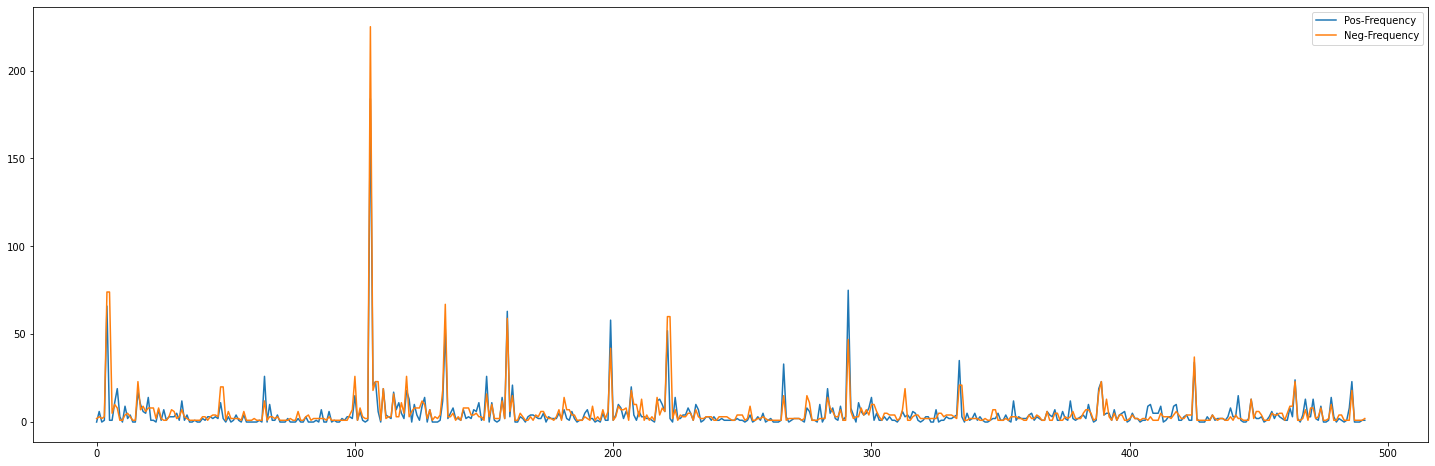

In [13]:
bigram_df.plot(figsize=(25,8))


## Analysis of the Bi-Gram Distribution:

The graph still presents a lot of overlap, however, this is expected as a bigram does not give much insight into the combination of strategies that is the netire dialogue.
Given the previous observation that in terms of simple counts there was no particular advantage to using one strategy over another, one begins to see a 
bit of a difference once sequence is added in the form of bigrams.
Through observation of the distribution of bigrams, a small difference can be seen with certain maximas beginning to form without overlap. 
However, the most present bigram: ('credibility-appeal', 'credibility-appeal') offers little-to-no advantage in determining whether a dialogue is successful or not.
Additionally, a particularly bad strategy is observed here: ('sos', 'logical-appeal') as when its used 98% of the time it is unsuccesful.
One begins to see the importance that sequence and combinations have in determining if a particular dialogue will be successful|
More often than not, any n-gram that presents a percentage of use with a deviation of at least 20% from 50% would result in an advantage in determining the outcome of a given dialogue, however, after taking into consideration non-overalpping bigrams another bad strategy is observed, this one incorporating to a more used strategy: ('logical-appeal', 'negative-to-inquiry'). This strategy is another with an above 90% use in unsuccessful dialogues. Thus, adding importance to the use of sequence and combination in the act of determining if a dialogue would be successful or not.

In [14]:
export_top_5(bigram_df, True)

N-Gram Number: 1   
Top Successful N-Gram: ('credibility-appeal', 'credibility-appeal')         Percentage of use: 44.987775061124694%  
Top Unsuccessful N-Gram: ('credibility-appeal', 'credibility-appeal')       Percentage of use: 55.012224938875306%

N-Gram Number: 2   
Top Successful N-Gram: ('other', 'other')                                   Percentage of use: 61.47540983606557%  
Top Unsuccessful N-Gram: ('<sos>', 'greeting')                              Percentage of use: 52.85714285714286%

N-Gram Number: 3   
Top Successful N-Gram: ('<sos>', 'greeting')                                Percentage of use: 47.14285714285714%  
Top Unsuccessful N-Gram: ('<sos>', 'logical-appeal')                        Percentage of use: 98.66666666666667%

N-Gram Number: 4   
Top Successful N-Gram: ('emotion-appeal', 'emotion-appeal')                 Percentage of use: 51.63934426229508%  
Top Unsuccessful N-Gram: ('donation-information', 'donation-information')   Percentage of use: 55.83333333333

<AxesSubplot:>

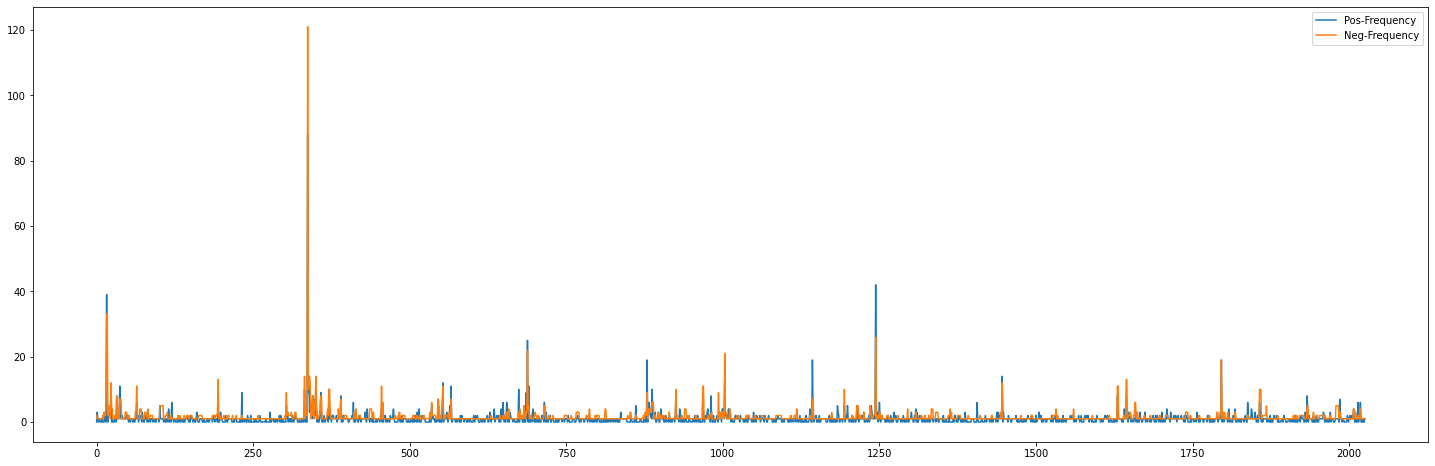

In [15]:
trigram_df.plot(figsize=(25,8))


## Analysis of the Tri-Gram Ditribution:

In regards to the visual provided by distribution of trigrams it can be observed that certain trigrams are more present. Additionally, some of the largest maximas belong to the unsuccessful dialogues, which, in other words means there are certain trigrams that when used significantly decrease the chances of the dialogue being successful.
Moreover, with the addition of a third element to the sequence it is important to note that they are getting more specific and thus bring larger deviations. It is unclear what overlap at this point would mean, however, my interpretation is that people hava a pre-determined generalization of how to persuade. Furthermore, what determines whether or not these strategies work is dependent on the persuadee's background. On the other hand, with enough trials and data one could attempt to devise a generalized persuasion strategy, as the deviation has increased based on the length of the n-gram analyzed.



In [16]:
export_top_5(trigram_df, True)

N-Gram Number: 1   
Top Successful N-Gram: ('credibility-appeal', 'credibility-appeal', 'credibility-appeal') Percentage of use: 42.10526315789473%  
Top Unsuccessful N-Gram: ('credibility-appeal', 'credibility-appeal', 'credibility-appeal') Percentage of use: 57.89473684210527%

N-Gram Number: 2   
Top Successful N-Gram: ('other', 'other', 'other')                          Percentage of use: 61.76470588235294%  
Top Unsuccessful N-Gram: ('<sos>', 'greeting', 'neutral-to-inquiry')        Percentage of use: 97.05882352941177%

N-Gram Number: 3   
Top Successful N-Gram: ('<sos>', 'greeting', 'greeting')                    Percentage of use: 54.166666666666664%  
Top Unsuccessful N-Gram: ('<sos>', 'greeting', 'greeting')                  Percentage of use: 45.83333333333333%

N-Gram Number: 4   
Top Successful N-Gram: ('emotion-appeal', 'emotion-appeal', 'emotion-appeal') Percentage of use: 53.191489361702125%  
Top Unsuccessful N-Gram: ('other', 'other', 'other')                        P

## Statistical Analysis of Data w/ Persuadee Background

Analysis with Background is still needed

## Conclusion

Following the baseline n-gram analysis of successful and unsuccessful dialogues, a few observations are made, first and foremost: usage of singular strategies provide no particular advantage in determining whether or not a dialogue is successful. Second, with the added layer of sequence and combination, deviation is more present, and some strategies begin to seem more useful than others for the task. Moreover, the tri-gram test further supports this claim offering more useful sequences and combinations. However, it should be noted that the the n-gram would have a maximum length where it is useful, and this length would be where the sequences and combinations become over-specific, as in the n-gram provided is only present in little-to-no other dialogues, which provides no outstanding advantage in the task at hand. Additionally, this limitation could be overwritten by the prescence of more dialogue examples, increasing the prescence of particular sequences.

Persuadee Background Conclusion Still Needed